In [50]:
import numpy as np # linear algebra
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import lightgbm as lgb
import xgboost as xgb

#import sklearn.external.joblib as extjoblib
import joblib
from joblib import Parallel, delayed

from sklearn.metrics import f1_score
#from sklearn.externals.joblib import Parallel, delayed
from sklearn.base import clone
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings("ignore")

In [51]:
from sklearn.preprocessing import LabelEncoder

# this only transforms the idhogar field, the other things this function used to do are done elsewhere
# idhogar : 가정 id  / 이코드는 idhogar 를 숫자로 바꾸는데 사용됨
def encode_data(df):
    df['idhogar'] = LabelEncoder().fit_transform(df['idhogar'])

# plot feature importance for sklearn decision trees    
# decision trees 의 중요도 피쳐
def feature_importance(forest, X_train, display_results=True):
    ranked_list = []
    zero_features = []
    
    importances = forest.feature_importances_

    indices = np.argsort(importances)[::-1]
    
    if display_results:
        # Print the feature ranking
        print("Feature ranking:")

    for f in range(X_train.shape[1]):
        if display_results:
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]) + " - " + X_train.columns[indices[f]])
        
        ranked_list.append(X_train.columns[indices[f]])
        
        if importances[indices[f]] == 0.0:
            zero_features.append(X_train.columns[indices[f]])
            
    return ranked_list, zero_features

In [52]:
def do_features(df):
    # 새로운 열 만들기
    feats_div = [('children_fraction', 'r4t1', 'r4t3'), 
                 ('working_man_fraction', 'r4h2', 'r4t3'),
                 ('all_man_fraction', 'r4h3', 'r4t3'),
                 ('human_density', 'tamviv', 'rooms'),
                 ('human_bed_density', 'tamviv', 'bedrooms'),
                 ('rent_per_person', 'v2a1', 'r4t3'),
                 ('rent_per_room', 'v2a1', 'rooms'),
                 ('mobile_density', 'qmobilephone', 'r4t3'),
                 ('tablet_density', 'v18q1', 'r4t3'),
                 ('mobile_adult_density', 'qmobilephone', 'r4t2'),
                 ('tablet_adult_density', 'v18q1', 'r4t2'),
                ]
    
    feats_sub = [('people_not_living', 'tamhog', 'tamviv'),
                 ('people_weird_stat', 'tamhog', 'r4t3')]

    for f_new, f1, f2 in feats_div:
        df['fe_' + f_new] = (df[f1] / df[f2]).astype(np.float32)       
    for f_new, f1, f2 in feats_sub:
        df['fe_' + f_new] = (df[f1] - df[f2]).astype(np.float32)
    
    # aggregation rules over household
    aggs_num = {'age': ['min', 'max', 'mean'],
                'escolari': ['min', 'max', 'mean']
               }
    
    aggs_cat = {'dis': ['mean']}
    
    # s_ : ['estadocivil', 'parentesco', 'instlevel'] 로 시작하는 칼럼들에 mean, count 넣기
    for s_ in ['estadocivil', 'parentesco', 'instlevel']:
        for f_ in [f_ for f_ in df.columns if f_.startswith(s_)]:
            aggs_cat[f_] = ['mean', 'count']

    # aggregation over household
    # **는 keyword argument (kwargs) 딕셔너리 형태로 함수 인자를 받는다는 뜻이다
    ## df_agg
    for name_, df_ in [('18', df.query('age >= 18'))]:
        df_agg = df_.groupby('idhogar').agg({**aggs_num, **aggs_cat}).astype(np.float32)
        df_agg.columns = pd.Index(['agg' + name_ + '_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
       # print(df_agg.columns)
        df = df.join(df_agg, how='left', on='idhogar')
        del df_agg

    # Drop id's
    df.drop(['Id'], axis=1, inplace=True)
    
    return df

In [53]:
# convert one hot encoded fields to label encoding
def convert_OHE2LE(df):
    tmp_df = df.copy(deep=True)
    for s_ in ['pared', 'piso', 'techo', 'abastagua', 'sanitario', 'energcocinar', 'elimbasu', 
               'epared', 'etecho', 'eviv', 'estadocivil', 'parentesco', 
               'instlevel', 'lugar', 'tipovivi',
               'manual_elec']:
        if 'manual_' not in s_:
            cols_s_ = [f_ for f_ in df.columns if f_.startswith(s_)]
        elif 'elec' in s_:
            cols_s_ = ['public', 'planpri', 'noelec', 'coopele']
        sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
        #deal with those OHE, where there is a sum over columns == 0
        if 0 in sum_ohe:
            print('The OHE in {} is incomplete. A new column will be added before label encoding'
                  .format(s_))
            # dummy colmn name to be added
            col_dummy = s_+'_dummy'
            # add the column to the dataframe
            tmp_df[col_dummy] = (tmp_df[cols_s_].sum(axis=1) == 0).astype(np.int8)
            # add the name to the list of columns to be label-encoded
            cols_s_.append(col_dummy)
            # proof-check, that now the category is complete
            sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
            if 0 in sum_ohe:
                 print("The category completion did not work")
        tmp_cat = tmp_df[cols_s_].idxmax(axis=1)
        tmp_df[s_ + '_LE'] = LabelEncoder().fit_transform(tmp_cat).astype(np.int16)
        if 'parentesco1' in cols_s_:
            cols_s_.remove('parentesco1')
        tmp_df.drop(cols_s_, axis=1, inplace=True)
    return tmp_df

# Read in the data and clean it up


In [54]:
train = pd.read_csv('G:/내 드라이브/ESAA_21_1/실습2/costa-rican-household-poverty-prediction/train.csv')
test = pd.read_csv('G:/내 드라이브/ESAA_21_1/실습2/costa-rican-household-poverty-prediction/test.csv')

test_ids = test.Id

In [55]:
def process_df(df_):
    # encode the idhogar
    encode_data(df_)
    
    # create aggregate features
    return do_features(df_)

train = process_df(train)
test = process_df(test)

train set에서 각 그룹에 속하는 사람의 수는 다음과 같다.

In [56]:
# some dependencies are Na, fill those with the square root of the square
train['dependency'] = np.sqrt(train['SQBdependency'])
test['dependency'] = np.sqrt(test['SQBdependency'])

# fill "no"s for education with 0s
train.loc[train['edjefa'] == "no", "edjefa"] = 0
train.loc[train['edjefe'] == "no", "edjefe"] = 0
test.loc[test['edjefa'] == "no", "edjefa"] = 0
test.loc[test['edjefe'] == "no", "edjefe"] = 0

# if education is "yes" and person is head of household, fill with escolari
train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "edjefa"] = train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "escolari"]
train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "edjefe"] = train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "escolari"]

test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "edjefa"] = test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "escolari"]
test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "edjefe"] = test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "escolari"]

# this field is supposed to be interaction between gender and escolari, but it isn't clear what "yes" means, let's fill it with 4
train.loc[train['edjefa'] == "yes", "edjefa"] = 4
train.loc[train['edjefe'] == "yes", "edjefe"] = 4

test.loc[test['edjefa'] == "yes", "edjefa"] = 4
test.loc[test['edjefe'] == "yes", "edjefe"] = 4

# convert to int for our models
train['edjefe'] = train['edjefe'].astype("int")
train['edjefa'] = train['edjefa'].astype("int")
test['edjefe'] = test['edjefe'].astype("int")
test['edjefa'] = test['edjefa'].astype("int")

# create feature with max education of either head of household
train['edjef'] = np.max(train[['edjefa','edjefe']], axis=1)
test['edjef'] = np.max(test[['edjefa','edjefe']], axis=1)

# fill some nas
train['v2a1']=train['v2a1'].fillna(0)
test['v2a1']=test['v2a1'].fillna(0)

test['v18q1']=test['v18q1'].fillna(0)
train['v18q1']=train['v18q1'].fillna(0)

train['rez_esc']=train['rez_esc'].fillna(0)
test['rez_esc']=test['rez_esc'].fillna(0)

train['fe_rent_per_person']=train['fe_rent_per_person'].fillna(0)
test['fe_rent_per_person']=test['fe_rent_per_person'].fillna(0)

train['fe_rent_per_room']=train['fe_rent_per_room'].fillna(0)
test['fe_rent_per_room']=test['fe_rent_per_room'].fillna(0)

train['fe_tablet_density']=train['fe_tablet_density'].fillna(0)
test['fe_tablet_density']=test['fe_tablet_density'].fillna(0)

train['fe_tablet_adult_density']=train['fe_tablet_adult_density'].fillna(0)
test['fe_tablet_adult_density']=test['fe_tablet_adult_density'].fillna(0)


train.loc[train.meaneduc.isnull(), "meaneduc"] = 0
train.loc[train.SQBmeaned.isnull(), "SQBmeaned"] = 0

test.loc[test.meaneduc.isnull(), "meaneduc"] = 0
test.loc[test.SQBmeaned.isnull(), "SQBmeaned"] = 0

# fix some inconsistencies in the data - some rows indicate both that the household does and does not have a toilet, 
# if there is no water we'll assume they do not
train.loc[(train.v14a ==  1) & (train.sanitario1 ==  1) & (train.abastaguano == 0), "v14a"] = 0
train.loc[(train.v14a ==  1) & (train.sanitario1 ==  1) & (train.abastaguano == 0), "sanitario1"] = 0

test.loc[(test.v14a ==  1) & (test.sanitario1 ==  1) & (test.abastaguano == 0), "v14a"] = 0
test.loc[(test.v14a ==  1) & (test.sanitario1 ==  1) & (test.abastaguano == 0), "sanitario1"] = 0

In [57]:
def train_test_apply_func(train_, test_, func_):
    test_['Target'] = 0
    xx = pd.concat([train_, test_])

    # shape[0] : 행의 개수
    xx_func = func_(xx)
    train_ = xx_func.iloc[:train_.shape[0], :]
    test_  = xx_func.iloc[train_.shape[0]:, :].drop('Target', axis=1)

    del xx, xx_func
    return train_, test_

In [58]:
# convert the one hot fields into label encoded
#train, test = train_test_apply_func(train, test, convert_OHE2LE)

# Geo aggregates

In [59]:
#cols_2_ohe = ['eviv_LE', 'etecho_LE', 'epared_LE', 'elimbasu_LE', 'energcocinar_LE', 'sanitario_LE', 'manual_elec_LE', 'pared_LE']
#cols_nums = ['age', 'meaneduc', 'dependency','hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total', 'bedrooms', 'overcrowding']

#def convert_geo2aggs(df_):
#    tmp_df = pd.concat([df_[(['lugar_LE', 'idhogar']+cols_nums)],
#                        pd.get_dummies(df_[cols_2_ohe], 
#                                       columns=cols_2_ohe)],axis=1)

#    geo_agg = tmp_df.groupby(['lugar_LE','idhogar']).mean().groupby('lugar_LE').mean().astype(np.float32)
#    geo_agg.columns = pd.Index(['geo_' + e for e in geo_agg.columns.tolist()])
    
#    del tmp_df
#    return df_.join(geo_agg, how='left', on='lugar_LE')

# add some aggregates by geography
#train, test = train_test_apply_func(train, test, convert_geo2aggs)

In [60]:
# add the number of people over 18 in each household
train['num_over_18'] = 0
train['num_over_18'] = train[train.age >= 18].groupby('idhogar').transform("count")
train['num_over_18'] = train.groupby("idhogar")["num_over_18"].transform("max")
train['num_over_18'] = train['num_over_18'].fillna(0)

test['num_over_18'] = 0
test['num_over_18'] = test[test.age >= 18].groupby('idhogar').transform("count")
test['num_over_18'] = test.groupby("idhogar")["num_over_18"].transform("max")
test['num_over_18'] = test['num_over_18'].fillna(0)

# add some extra features, these were taken from another kernel
def extract_features(df):
    df['bedrooms_to_rooms'] = df['bedrooms']/df['rooms']
    df['rent_to_rooms'] = df['v2a1']/df['rooms']
    df['tamhog_to_rooms'] = df['tamhog']/df['rooms'] # tamhog - size of the household
    df['r4t3_to_tamhog'] = df['r4t3']/df['tamhog'] # r4t3 - Total persons in the household
    df['r4t3_to_rooms'] = df['r4t3']/df['rooms'] # r4t3 - Total persons in the household
    df['v2a1_to_r4t3'] = df['v2a1']/df['r4t3'] # rent to people in household
    df['v2a1_to_r4t3'] = df['v2a1']/(df['r4t3'] - df['r4t1']) # rent to people under age 12
    df['hhsize_to_rooms'] = df['hhsize']/df['rooms'] # rooms per person
    df['rent_to_hhsize'] = df['v2a1']/df['hhsize'] # rent to household size
    df['rent_to_over_18'] = df['v2a1']/df['num_over_18']
    # some households have no one over 18, use the total rent for those
    df.loc[df.num_over_18 == 0, "rent_to_over_18"] = df[df.num_over_18 == 0].v2a1
    
extract_features(train)    
extract_features(test)

In [61]:
# drop duplicated columns
needless_cols = ['r4t3', 'tamhog', 'tamviv', 'hhsize', 'v18q', 'v14a', 'agesq',
                 'mobilephone', 'female', ]

instlevel_cols = [s for s in train.columns.tolist() if 'instlevel' in s]

needless_cols.extend(instlevel_cols)

train = train.drop(needless_cols, axis=1)
test = test.drop(needless_cols, axis=1)

In [62]:

pd.options.display.max_columns = 176
train.head()

,v2a1,hacdor,rooms,hacapo,refrig,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,escolari,rez_esc,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,...,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,Target,fe_children_fraction,fe_working_man_fraction,fe_all_man_fraction,fe_human_density,fe_human_bed_density,fe_rent_per_person,fe_rent_per_room,fe_mobile_density,fe_tablet_density,fe_mobile_adult_density,fe_tablet_adult_density,fe_people_not_living,fe_people_weird_stat,agg18_age_MIN,agg18_age_MAX,agg18_age_MEAN,agg18_escolari_MIN,agg18_escolari_MAX,agg18_escolari_MEAN,agg18_dis_MEAN,agg18_estadocivil1_MEAN,agg18_estadocivil1_COUNT,agg18_estadocivil2_MEAN,agg18_estadocivil2_COUNT,agg18_estadocivil3_MEAN,agg18_estadocivil3_COUNT,agg18_estadocivil4_MEAN,agg18_estadocivil4_COUNT,agg18_estadocivil5_MEAN,agg18_estadocivil5_COUNT,agg18_estadocivil6_MEAN,agg18_estadocivil6_COUNT,agg18_estadocivil7_MEAN,agg18_estadocivil7_COUNT,agg18_parentesco1_MEAN,agg18_parentesco1_COUNT,agg18_parentesco2_MEAN,agg18_parentesco2_COUNT,agg18_parentesco3_MEAN,agg18_parentesco3_COUNT,agg18_parentesco4_MEAN,agg18_parentesco4_COUNT,agg18_parentesco5_MEAN,agg18_parentesco5_COUNT,agg18_parentesco6_MEAN,agg18_parentesco6_COUNT,agg18_parentesco7_MEAN,agg18_parentesco7_COUNT,agg18_parentesco8_MEAN,agg18_parentesco8_COUNT,agg18_parentesco9_MEAN,agg18_parentesco9_COUNT,agg18_parentesco10_MEAN,agg18_parentesco10_COUNT,agg18_parentesco11_MEAN,agg18_parentesco11_COUNT,agg18_parentesco12_MEAN,agg18_parentesco12_COUNT,edjef,num_over_18,bedrooms_to_rooms,rent_to_rooms,tamhog_to_rooms,r4t3_to_tamhog,r4t3_to_rooms,v2a1_to_r4t3,hhsize_to_rooms,rent_to_hhsize,rent_to_over_18
0,190000.0,0,3,0,1,0.0,0,1,1,0,0,0,0,1,10,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,401,...,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,4,0.00,1.0,1.0,0.333333,1.000000,190000.0,63333.332031,1.00,0.00,1.0,0.000000,0.0,0.0,43.0,43.0,43.0,10.0,10.0,10.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,10,1.0,0.333333,63333.333333,0.333333,1.0,0.333333,190000.0,0.333333,190000.0,190000.0
1,135000.0,0,4,0,1,1.0,0,1,1,0,0,0,0,1,12,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,171,...,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4,0.00,1.0,1.0,0.250000,1.000000,135000.0,33750.000000,1.00,1.00,1.0,1.000000,0.0,0.0,67.0,67.0,67.0,12.0,12.0,12.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,12,1.0,0.250000,33750.000000,0.250000,1.0,0.250000,135000.0,0.250000,135000.0,135000.0
2,0.0,0,8,0,1,0.0,0,0,0,0,1,1,0,1,11,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,522,...,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,4,0.00,0.0,0.0,0.125000,0.500000,

# modelling

<AxesSubplot:>

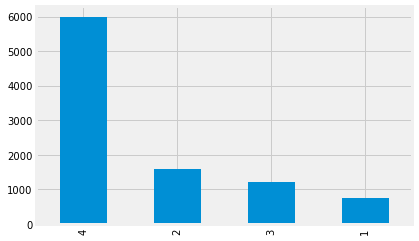

In [63]:
y=train['Target']
s=y.value_counts()
s.plot(kind="bar")

In [64]:
def split_data(train, y, sample_weight=None, households=None, test_percentage=0.20, seed=None):
    # uncomment for extra randomness
#     np.random.seed(seed=seed)
    
    train2 = train.copy()
    
    # pick some random households to use for the test data
    cv_hhs = np.random.choice(households, size=int(len(households) * test_percentage), replace=False)
    
    # select households which are in the random selection
    cv_idx = np.isin(households, cv_hhs)
    X_test = train2[cv_idx]
    y_test = y[cv_idx]

    X_train = train2[~cv_idx]
    y_train = y[~cv_idx]
    
    if sample_weight is not None:
        y_train_weights = sample_weight[~cv_idx]
        return X_train, y_train, X_test, y_test, y_train_weights
    
    return X_train, y_train, X_test, y_test

In [65]:
X = train.query('parentesco1==1')
# X = train.copy()

# pull out and drop the target variable
y = X['Target'] - 1
X = X.drop(['Target'], axis=1)

np.random.seed(seed=None)

train2 = X.copy()

train_hhs = train2.idhogar

households = train2.idhogar.unique()
cv_hhs = np.random.choice(households, size=int(len(households) * 0.15), replace=False)

cv_idx = np.isin(train2.idhogar, cv_hhs)

X_test = train2[cv_idx]
y_test = y[cv_idx]

X_train = train2[~cv_idx]
y_train = y[~cv_idx]

# train on entire dataset
X_train = train2
y_train = y

train_households = X_train.idhogar

In [66]:
# figure out the class weights for training with unbalanced classes
y_train_weights = class_weight.compute_sample_weight('balanced', y_train, indices=None)


In [67]:
# drop some features which aren't used by the LGBM or have very low importance
extra_drop_features = [
 'agg18_estadocivil1_MEAN',
 'agg18_estadocivil6_COUNT',
 'agg18_estadocivil7_COUNT',
 'agg18_parentesco10_COUNT',
 'agg18_parentesco11_COUNT',
 'agg18_parentesco12_COUNT',
 'agg18_parentesco1_COUNT',
 'agg18_parentesco2_COUNT',
 'agg18_parentesco3_COUNT',
 'agg18_parentesco4_COUNT',
 'agg18_parentesco5_COUNT',
 'agg18_parentesco6_COUNT',
 'agg18_parentesco7_COUNT',
 'agg18_parentesco8_COUNT',
 'agg18_parentesco9_COUNT',
     'geo_hogar_mayor',
     'num_over_18',
    'rez_esc'
 'geo_elimbasu_LE_4',
 'geo_energcocinar_LE_1',
 'geo_energcocinar_LE_2',
 'geo_epared_LE_0',
 'geo_hogar_mayor',
 'geo_manual_elec_LE_2',
 'geo_pared_LE_3',
 'geo_pared_LE_4',
 'geo_pared_LE_5',
 'geo_pared_LE_6',
 'num_over_18',
 'parentesco_LE',
 'rez_esc']

In [68]:
#xgb_drop_cols = extra_drop_features + ["idhogar",  'parentesco1']

# 발표 소프트맥스 로지스틱 회귀분석

In [69]:
#import ML models and metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [70]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2973 entries, 0 to 9552
Columns: 192 entries, v2a1 to rent_to_over_18
dtypes: float32(58), float64(19), int32(4), int64(111)
memory usage: 3.7 MB


In [71]:
train_null = X_train.isnull().sum()
train_null[train_null > 0]

Series([], dtype: int64)

#### 로지스틱 회귀분석을 사용하기 위해 캐글에 올라온 one hot 인코딩 방식을 그대로 사용하였으며, na값이 없도록 처리하였습니다. 

In [72]:
logR = LogisticRegression(multi_class='multinomial', class_weight='balanced',random_state = 42, solver='lbfgs')
logR.fit(X_train,y_train)
preds_log = logR.predict(X_test)
cv_score = cross_val_score(logR, X_train, y_train, cv = 10, scoring = scorer)
print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.251 with std = 0.0274


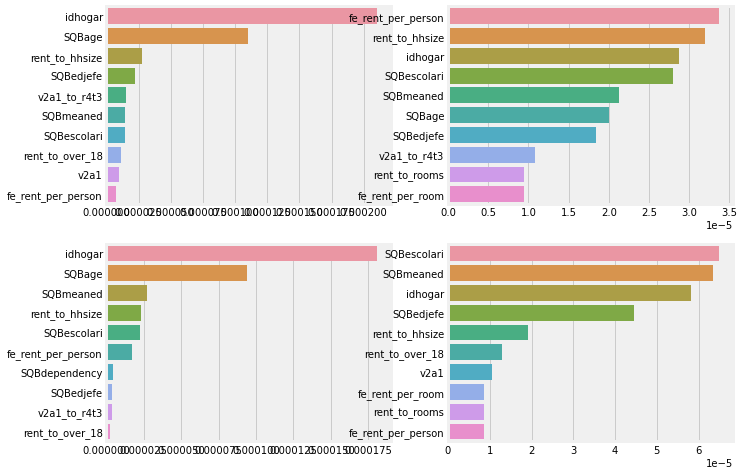

In [73]:
plt.figure(figsize = (10,8))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    coef = pd.Series(logR.coef_[i],index = X_train.columns)
    coef_sort=abs(coef).sort_values(ascending=False)[:10]
    sns.barplot(x=coef_sort.values,y=coef_sort.index,ax=ax)

#### 각 그룹별 로지스틱 회귀모델의 계수를 나타낸 것입니다. 결과와 상관 없는 id변수의 계수가 크게 책정되어 id변수를 제거하였습니다.  제곱 변수들의 경우 본래의 변수가 데이터에 남아있기 때문에 의미 없는 변수라고 생각하여 제거하였습니다. 또한 값이 매우 커 로지스틱 회귀모델의 계수를 키워 과적합을 우려되기도 하였습니다.  가구의 가장인지 여부를 결정하는 변수도 target에 영향을 주지 않을 것으로 보여 마찬가지로 제거하였습니다.  

In [98]:
logR_drop_cols = ["idhogar",  'parentesco1','num_over_18',    'rez_esc'] + list([i for i in X_train.columns if i.startswith("SQB")])+ list([i for i in X_train.columns if i.startswith("agg18")])  
#제거할 변수들

In [88]:
logR = LogisticRegression(multi_class='multinomial', class_weight='balanced',random_state = 42, solver='lbfgs')
logR.fit(X_train.drop(logR_drop_cols , axis=1),y_train)
preds_log = logR.predict(X_test.drop(logR_drop_cols , axis=1))
cv_score = cross_val_score(logR, X_train.drop(logR_drop_cols , axis=1), y_train, cv = 10, scoring = scorer)
print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.19 with std = 0.0269


#### 몇몇 변수를 삭제하였으나 f1값이 더 떨어져서 몇몇 변수에 log변환을 하였습니다. 

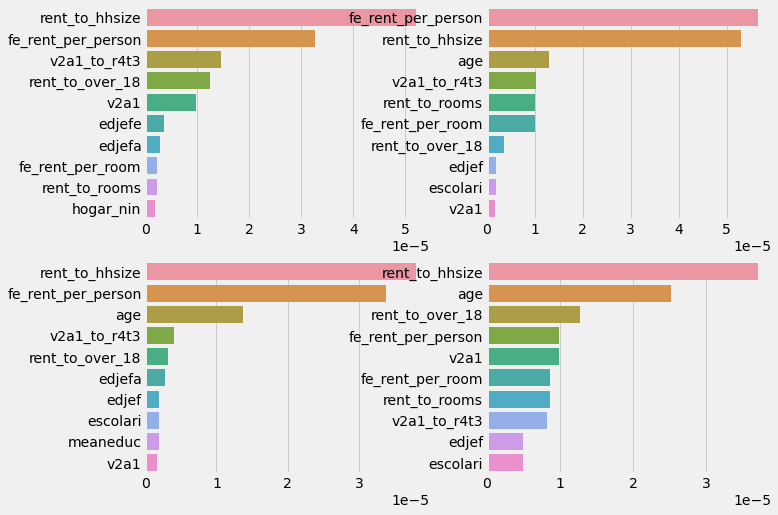

In [89]:
plt.figure(figsize = (10,8))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    coef = pd.Series(logR.coef_[i],index = X_train.drop(logR_drop_cols , axis=1).columns)
    coef_sort=abs(coef).sort_values(ascending=False)[:10]
    sns.barplot(x=coef_sort.values,y=coef_sort.index,ax=ax)

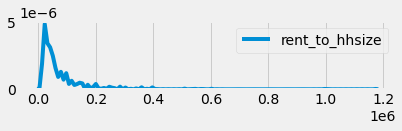

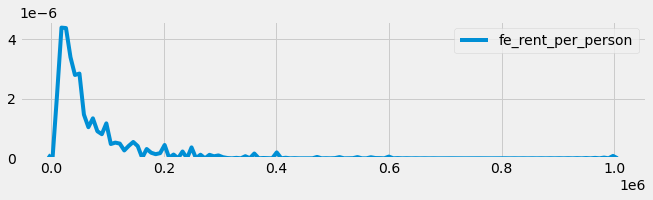

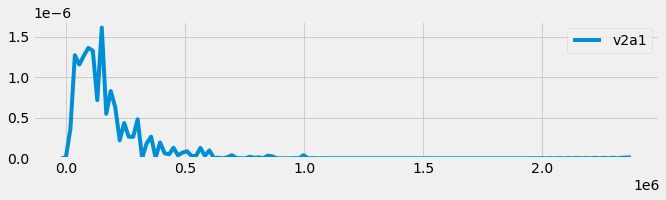

<Figure size 720x576 with 0 Axes>

In [90]:
ha = [X_train.rent_to_hhsize,X_train.fe_rent_per_person,X_train.v2a1]
import seaborn as sns
for i in range(len(ha)):
    ax = plt.subplot(3, 1, i + 1)
    plt.figure(figsize = (10, 8))
    plt.style.use('fivethirtyeight')
    sns.kdeplot(ha[i],ax=ax)

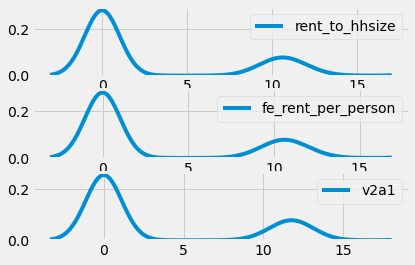

In [91]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()
haha = ['rent_to_hhsize','fe_rent_per_person','v2a1']
ha = [X_train_2.rent_to_hhsize,X_train_2.fe_rent_per_person,X_train_2.v2a1]
for i in range(len(ha)):
    ax = plt.subplot(3, 1, i + 1)
    X_train_2[haha[i]]= np.log1p(X_train[haha[i]])

    X_test_2[haha[i]]= np.log1p(X_test[haha[i]])
    sns.kdeplot(ha[i],ax=ax)


#### 'rent_to_hhsize' 'fe_rent_per_person' 'v2a1' 임대료가 다른 값에 비해 크기가 매우 크기 때문에 임대료와 관련된 위 3개 변수를 로그변환하여 사용하였습니다.

In [92]:
logR = LogisticRegression(multi_class='multinomial', class_weight='balanced',random_state = 42, solver='lbfgs')
logR.fit(X_train_2.drop(logR_drop_cols , axis=1),y_train)
preds_log = logR.predict(X_test_2.drop(logR_drop_cols , axis=1))
cv_score = cross_val_score(logR, X_train_2.drop(logR_drop_cols , axis=1), y_train, cv = 10, scoring = scorer)
print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.2128 with std = 0.0483


#### f 값이 조금 증가한 것을 볼 수 있습니다.

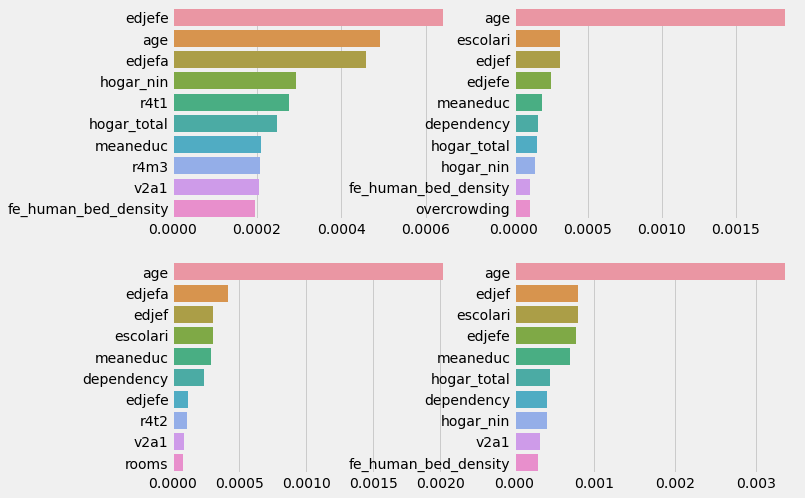

In [93]:
plt.figure(figsize = (10,8))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    coef = pd.Series(logR.coef_[i],index = X_train_2.drop(logR_drop_cols , axis=1).columns)
    coef_sort=abs(coef).sort_values(ascending=False)[:10]
    sns.barplot(x=coef_sort.values,y=coef_sort.index,ax=ax)

#### 이 변수들을 가지고 로지스틱 회귀분석의 파라매터를 조정하였습니다.
#### 저희가 이번에 사용한 데이터와 같이 이진분류가 아닌 다항분류의 경우 소프트맥스 함수를 사용하여 분석하여 소프트맥스 회귀분석이라고도 한다고 합니다.
#### 조정한 파라매터는 월요일에 공부한 alpha 값의 역수로  c가 높을수록 계수에 대한 규제가 줄어듭니다. c를 조절하여 l2 규제를 사용하엿습니다

In [94]:
params = {'C' : [1,10,100,500,1000,5000,10000]}
grid_cv = GridSearchCV(logR,param_grid=params, scoring = scorer,cv=10,verbose=1)
grid_cv.fit(X_train_2.drop(logR_drop_cols , axis=1),y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   18.3s finished


GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight='balanced',
                                          multi_class='multinomial',
                                          random_state=42),
             param_grid={'C': [1, 10, 100, 500, 1000, 5000, 10000]},
             scoring=make_scorer(f1_score, average=macro), verbose=1)

In [95]:
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:',grid_cv.best_params_)

GridSearchCV 최고 평균 정확도 수치: 0.2404
GridSearchCV 최적 하이퍼 파라미터: {'C': 10}


#### 가장 적절한 c 값은 10이었으며 f 값은 0.24였습니다.

In [97]:
best_logR=grid_cv.best_estimator_
pred1 = best_logR.predict(X_test.drop(logR_drop_cols , axis=1))
accuarcy = accuracy_score(y_test,pred1)
print('로지스틱 회귀분석 예측 정확도:{0:.4f}'.format(accuarcy))

로지스틱 회귀분석 예측 정확도:0.3528
